In [1]:
import sys
sys.path.append("/home/zhhu/workspaces/deepinv/")

In [2]:
from datetime import datetime
from functools import partial
import deepinv as dinv
from pathlib import Path
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
from deepinv.models import DRUNet
from deepinv.physics import GaussianNoise
from deepinv.optim.data_fidelity import L2
from deepinv.optim.prior import PnP
from deepinv.optim.optimizers import optim_builder
from deepinv.utils.demo import load_url_image, get_image_url
from deepinv.utils.plotting import plot, plot_curves
from deepinv.optim.phase_retrieval import correct_global_phase, cosine_similarity, spectral_methods, default_preprocessing
from deepinv.models.complex import to_complex_denoiser

In [3]:
device = dinv.utils.get_freer_gpu() if torch.cuda.is_available() else "cpu"
device

Selected GPU 0 with 32491 MiB free memory 


device(type='cuda', index=0)

torch.Size([1, 1, 64, 64])


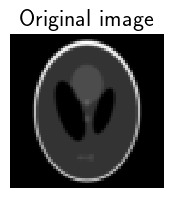

In [4]:
# Set up the variable to fetch dataset and operators.
img_size = 64
url = get_image_url("SheppLogan.png")
img = load_url_image(
    url=url, img_size=img_size, grayscale=True, resize_mode="resize", device=device
)
print(img.shape)
plot(img, titles="Original image")

In [5]:
# generate phase signal

# The phase is computed as 2*pi*x - pi, where x is the original image.
x = torch.exp(1j*img*torch.pi - 0.5j*torch.pi).to(device)

# Every element of the signal should have unit norm.
assert torch.allclose(x.real**2 + x.imag**2, torch.tensor(1.0))

In [7]:
# performance quickly degrades between 0.01 and 0.04
sigma = 0.04
physics = dinv.physics.StructuredRandomPhaseRetrieval(
    input_shape=(1, img_size, img_size),
    output_shape=(1, 2*img_size, 2*img_size),
    dtype=torch.cfloat,
    device=device,
    noise_model=GaussianNoise(sigma=sigma),
    sensor_model=partial(torch.clip, min=0),
)
# y = physics(x)
# # y = torch.clip(y, 0)
# y.shape

In [10]:
physics.B

StructuredRandom(
  (noise_model): GaussianNoise()
)

In [111]:
print(physics.noise_model(physics.A(x)).dtype)

RuntimeError: clamp is not supported for complex types

In [103]:
y.min(), y.max()

(tensor(0., device='cuda:1'), tensor(2.1729, device='cuda:1'))

In [100]:
x_spec = spectral_methods(y, physics, n_iter=500)

tensor(0.0217, device='cuda:1')


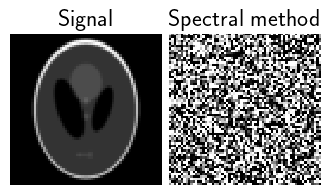

In [101]:
print(cosine_similarity(x_spec, x))
x_spec = correct_global_phase(x_spec, x)
plot([img, torch.angle(x_spec)/torch.pi + 0.5],titles=["Signal","Spectral method"],rescale_mode='clip')

In [20]:
def spectral_methods_wrapper(y, physics, **kwargs):
    x = spectral_methods(y, physics, n_iter=2500, **kwargs)
    z = spectral_methods(y, physics, n_iter=2500, **kwargs)
    return {"est": (x, z)}

In [21]:
# Algorithm parameters
data_fidelity = L2()
prior = dinv.optim.prior.Zero()
params_algo = {"stepsize": 1e-2, "g_params": 0.00}
#params_algo = {"stepsize": 0.05, "g_params": 0.00}
max_iter = 10000
early_stop = True
verbose = True

/opt/conda/envs/deepinv/lib/python3.9/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/conda/envs/deepinv/lib/python3.9/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


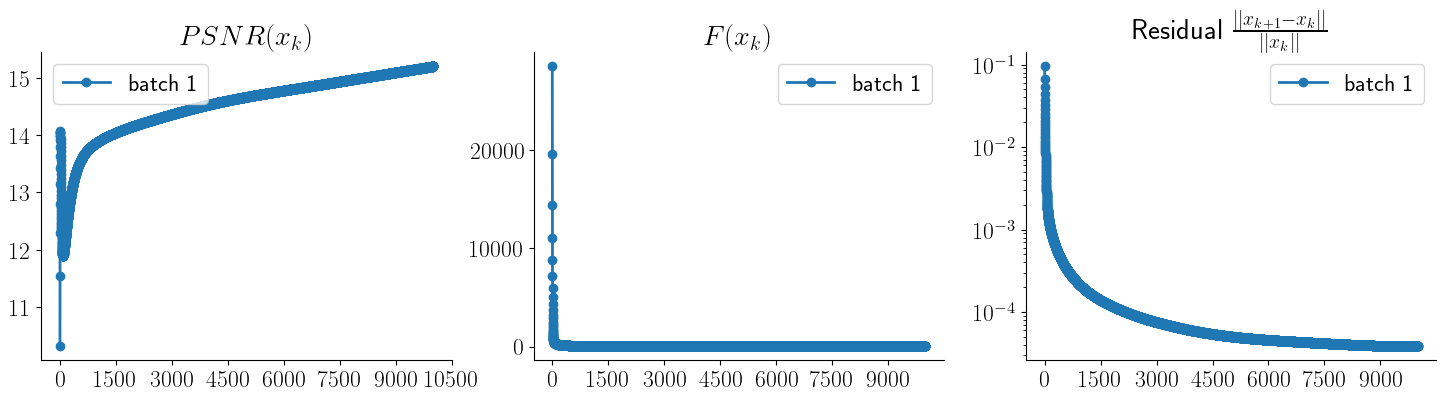

In [ ]:
model = optim_builder(
    iteration="PGD",
    prior=prior,
    data_fidelity=data_fidelity,
    early_stop=early_stop,
    max_iter=max_iter,
    verbose=verbose,
    params_algo=params_algo,
    custom_init=spectral_methods_wrapper,
)

# Run the algorithm
x_phase_est, metrics = model(y, physics, x_gt=x, compute_metrics=True)
plot_curves(metrics, show=True)

Image 0, channel 0 does not have a global phase shift.


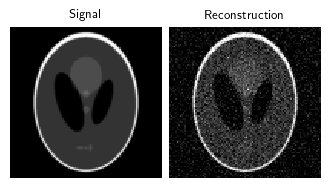

Cosine similarity: tensor(0.9396, device='cuda:0')


In [ ]:
# correct possible global phase shifts
x_est = correct_global_phase(x_phase_est, x)
# extract phase information and normalize to the range [0, 1]
x_est = torch.angle(x_est) / torch.pi + 0.5
plot([img, x_est],titles=["Signal","Reconstruction"],rescale_mode='clip')
print("Cosine similarity:", cosine_similarity(x, x_phase_est))